In [247]:
import geonamescache
import re
import math
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from unidecode import unidecode
from mpl_toolkits.basemap import Basemap


gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
cities = gc.get_cities()
file = open("data/headlines.txt", "r")

lines = file.readlines()
cityList = []
for city in cities.items():
    cityName = city[1]['name']
    cityList.append(cityName)
cityList.sort(reverse=True)

countryList = []
for country in countries.items():
    countryName = country[1]['name']
    countryList.append(countryName)
countryList.sort(reverse=True)


In [248]:
regString = ""
originalCity = {}
for cityName in cityList:
    #
    origName = cityName
    cityName = unidecode(re.escape(cityName))
    originalCity[cityName] = origName
    cityName = cityName.replace("\ ", " ")
    cityName = r'\b' + cityName + r'\b'
    if(regString != ""):
        regString = regString + '|'+ cityName
    else:
        regString = regString + cityName
        
print(regString)
regExpCity = re.compile(r''+regString)

print(pd.DataFrame(originalCity, index=[0]).T.head())
print(len(originalCity))
regStringCountry = ""
for countryName in countryList:
    countryName = unidecode(re.escape(countryName))
    countryName = countryName.replace("\ ", " ")
    countryName = r'\b' + countryName + r'\b'
    if(regStringCountry != ""):
        regStringCountry = regStringCountry + "|" + countryName 
    else:
        regStringCountry = regStringCountry + countryName


regExpCountry = re.compile(r''+regStringCountry)

\b'Ain el Turk\b|\b'Ain el Melh\b|\b'Ain el Hammam\b|\b'Ain el Berd\b|\b'Ain el Bell\b|\b'Ain Merane\b|\b'Ain Deheb\b|\b'Ain Benian\b|\b'Ain Abid\b|\b'Izra\b|\b'Izbat al Burj\b|\b'Irbin\b|\b'Ibri\b|\b'Ewa Gentry\b|\b'Ain el Hadjel\b|\b'Ayn al 'Arab\b|\b'Aqrah\b|\b'Anjarah\b|\b'Anat al Qadimah\b|\b'Anah\b|\b'Amran\b|\b'Ali al Gharbi\b|\b'Ajlun\b|\b'Ajab Shir\b|\b'Afrin\b|\b'Afak\b|\b'Abasan al Kabirah\b|\bTikapur\b|\bHayy al Quwaysimah\b|\bHawsh 'Isa\b|\bHawalli\b|\bHarasta\b|\bHamah\b|\bHalhul\b|\bHalwan\b|\bHalfaya\b|\bHalabjah\b|\bHajjah\b|\bHadithah\b|\bZuunmod\b|\bBerezhani\b|\b@hm@db@yli\b|\bZdar nad Sazavou Druhy\b|\bZdar nad Sazavou\b|\bZilina\b|\bZiar nad Hronom\b|\bZatec\b|\bZywiec\b|\bZyrardow\b|\bZory\b|\bZoliborz\b|\bZary\b|\bZagan\b|\bZabbar\b|\bUiju\b|\bUn\b|\bTulkarm\b|\bTubas\b|\bTamiyah\b|\bTubarjal\b|\bTayyibat al Imam\b|\bTalkha\b|\bTahta\b|\bTafas\b|\bSuto Orizare\b|\bSumperk\b|\bSilainiai\b|\bSibenik\b|\bSiauliai\b|\bSeskine\b|\bSala\b|\bSabac\b|\bSirnak\b|\bSamita

                               0
'Ain\ el\ Turk      ’Aïn el Turk
'Ain\ el\ Melh      ’Aïn el Melh
'Ain\ el\ Hammam  ’Aïn el Hammam
'Ain\ el\ Berd      ’Aïn el Berd
'Ain\ el\ Bell      ’Aïn el Bell
23022


In [249]:
listOfHeadlines = []
for line in lines:
    line = line.replace("\n", "")
    decoded = unidecode((line))
    matchedCities = re.findall(r''+regString,decoded)
    matchedCountries = re.findall(r''+regStringCountry,decoded)
    
    newDictObject = {"headline": decoded, "cities": matchedCities, "countries": matchedCountries}
    listOfHeadlines.append(newDictObject)
countMissed = 0
for item in listOfHeadlines:
    if(item["countries"] == [] and item["cities"] == []):
        print(item)
        countMissed += 1
print("total missed: " + str(countMissed))

#Rio De Janeiro vs Rio de Janeiro is easier to fix in the data compared to in the code - as otherwise we will end up catching a whole lot of 'Man' and 'Of' in the cities list

{'headline': 'Louisiana Zika cases up to 26', 'cities': [], 'countries': []}
{'headline': 'Zika infects pregnant woman in Cebu', 'cities': [], 'countries': []}
{'headline': 'Spanish Flu Sighted in Antigua', 'cities': [], 'countries': []}
{'headline': 'Carnival under threat in Rio De Janeiro due to Zika outbreak', 'cities': [], 'countries': []}
{'headline': 'Zika case reported in Oton', 'cities': [], 'countries': []}
{'headline': 'Hillsborough uses innovative trap against Zika 20 minutes ago', 'cities': [], 'countries': []}
{'headline': 'Maka City Experiences Influenza Outbreak', 'cities': [], 'countries': []}
{'headline': 'More Zika patients reported in Mcallen', 'cities': [], 'countries': []}
{'headline': 'West Nile Virus Outbreak in Saint Johns', 'cities': [], 'countries': []}
{'headline': 'More people in Mclean are infected with Hepatitis A every year', 'cities': [], 'countries': []}
{'headline': 'Malaria Exposure in Sussex', 'cities': [], 'countries': []}
{'headline': 'Greenwich Es

In [250]:
df = pd.DataFrame(listOfHeadlines)
print(df.head())

                                  headline           cities countries
0                 Zika Outbreak Hits Miami          [Miami]        []
1          Could Zika Reach New York City?  [New York City]        []
2        First Case of Zika in Miami Beach    [Miami Beach]        []
3  Mystery Virus Spreads in Recife, Brazil         [Recife]  [Brazil]
4  Dallas man comes down with case of Zika         [Dallas]        []


In [251]:
def count_doubles():
    for entry in df.index:
        if(len(df["cities"][entry]) > 1):
           print("Double city ",df["cities"][entry], df["headline"][entry], " at location ", entry)
        if(len(df["countries"][entry]) > 1):
           print(df["countries"][entry], df["headline"][entry])
        if(len(df["countries"][entry]) < 1 and len(df["cities"][entry]) < 1):
            print(df["countries"][entry], df["headline"][entry])
count_doubles()

[] Louisiana Zika cases up to 26
[] Zika infects pregnant woman in Cebu
Double city  ['Tampa', 'Bay'] Tampa Bay Area Zika Case Count Climbs  at location  21
Double city  ['Kuala Lumpur', 'Hit'] Kuala Lumpur is Hit By Zika Threat  at location  33
[] Spanish Flu Sighted in Antigua
[] Carnival under threat in Rio De Janeiro due to Zika outbreak
[] Zika case reported in Oton
[] Hillsborough uses innovative trap against Zika 20 minutes ago
[] Maka City Experiences Influenza Outbreak
Double city  ['Seminole', 'Florida'] Zika Patient in Seminole, Florida  at location  98
Double city  ['Can', 'Vero Beach'] Can Zika make it here to Vero Beach?  at location  101
Double city  ['Spring', 'Fort Lauderdale'] Spring break ruined by Zika in Fort Lauderdale  at location  120
Double city  ['Batangas', 'Hit'] Batangas Tourism Takes a Hit as Virus Spreads  at location  134
[] More Zika patients reported in Mcallen
[] West Nile Virus Outbreak in Saint Johns
Double city  ['Belmont', 'Belmont'] Zika in Belmo

# Clearing out double cities (countries was not a problem!)
(And the hit + spring!)


In [252]:
#Ugly code, but hey!
df.at[21, "cities"] = ["Tampa"]
df.at[33, "cities"] = ["Kuala Lumpur"]
df.at[98, "cities"] = ["Seminole"]
df.at[101, "cities"] = ["Vero Beach"]
df.at[120, "cities"] = ["Fort Lauerdale"]
df.at[134, "cities"] = ["Batangas"]
df.at[159, "cities"] = ["Belmont"]
for entry in df.index:
    if(len(df["countries"][entry]) < 1 and len(df["cities"][entry]) < 1):
           df.drop([entry], inplace=True)
count_doubles()

# Getting lat/long, deciding as well that the first city returned is an ok heuristic
(In reality, we could probably use some contextual clues to find out which city it is, but this is likely also a very risky move)

In [253]:
df.insert(3, "latitude", pd.Series([]), allow_duplicates=True)
df.insert(4, "longitude", pd.Series([]), allow_duplicates=True)
df.insert(5, "countrycode", pd.Series([],dtype="str"), allow_duplicates=True)
df.insert(6, "country", "", allow_duplicates=True)
df.insert(7, "city", "", allow_duplicates=True)
print(df.head())

                                  headline           cities countries  \
0                 Zika Outbreak Hits Miami          [Miami]        []   
1          Could Zika Reach New York City?  [New York City]        []   
2        First Case of Zika in Miami Beach    [Miami Beach]        []   
3  Mystery Virus Spreads in Recife, Brazil         [Recife]  [Brazil]   
4  Dallas man comes down with case of Zika         [Dallas]        []   

   latitude  longitude countrycode country city  
0       NaN        NaN         NaN               
1       NaN        NaN         NaN               
2       NaN        NaN         NaN               
3       NaN        NaN         NaN               
4       NaN        NaN         NaN               


We should probably in reality look for countries too...

In [254]:

for entry in df.index:
    #We'll prefer cities over countries, more specific
    if(len(df["cities"][entry]) > 0):
        targetCity = gc.get_cities_by_name(df["cities"][entry][0])
        if(len(targetCity) > 0):
            targetCityDict = targetCity[0]
            for value in targetCityDict.values():
                df.at[entry,"latitude"] = value["latitude"]
                df.at[entry,"longitude"] = value["longitude"]
                df.at[entry,"countrycode"] = value["countrycode"]
for entry in df.index:
    if(len(df["cities"][entry]) > 0):
        df.at[entry,"city"] = df["cities"][entry][0]
    if(len(df["countries"][entry]) > 0):
        df.at[entry,"country"] = df["countries"][entry][0]
df = df.drop(['countries', 'cities'], axis=1)
df.dropna(inplace=True)
print(df.head())

                                  headline  latitude  longitude countrycode  \
0                 Zika Outbreak Hits Miami  25.77427  -80.19366          US   
1          Could Zika Reach New York City?  40.71427  -74.00597          US   
2        First Case of Zika in Miami Beach  25.79065  -80.13005          US   
3  Mystery Virus Spreads in Recife, Brazil  -8.05389  -34.88111          BR   
4  Dallas man comes down with case of Zika  32.78306  -96.80667          US   

  country           city  
0                  Miami  
1          New York City  
2            Miami Beach  
3  Brazil         Recife  
4                 Dallas  


In [255]:
count = 0
for entry in df.index:
    if(not math.isnan(df["latitude"][entry]) and not math.isnan(df["longitude"][entry])):
        count += 1
print("Total entries with long/lat ", count)

Total entries with long/lat  581


# As the documentation for get_countries is pretty lacking, skipping countries atm

# Plot the distribution of headlines
(Surprise surprise, one country outweighs them all!)

In [256]:
df_countrycode = pd.DataFrame(df['countrycode'].values)
df_plot = df_countrycode.apply(pd.value_counts)
df_plot["Country Code"] = df_plot.index
df_plot.columns = ["Occurrences","Country Code"]

# KMeans

In [257]:
def elbow(df):
####
#Running some standard elbow code - courtesy of https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
    sse = [] #SUM OF SQUARED ERROR
    for k in range(1,11):
        km = KMeans(n_clusters=k, random_state=2)
        km.fit(df)
        sse.append(km.inertia_)
    sns.set_style("whitegrid")
    g=sns.lineplot(x=range(1,11), y=sse)

    g.set(xlabel ="Number of cluster (k)", 
          ylabel = "Sum Squared Error", 
          title ='Elbow Method')

    plt.show()
###

#Slightly surprised that this gives 2-3?

# Basic scatterplot of the fits and centroids - notice the shape

In [258]:
def kmns(df, n_cluster):
    cluster_model = KMeans(n_clusters=n_cluster)

    list_long = df["longitude"]
    list_lat = df["latitude"]
    print(list_long.isnull().values.any())
    print(list_lat.isnull().values.any())
    list_long.dropna(inplace=True)
    list_lat.dropna(inplace=True)

    cluster_df = pd.concat([list_long,list_lat], axis=1, keys=["longitude", "latitude"])
    cluster_df.dropna(inplace=True)
    elbow(cluster_df)

    assigned_coordinates = cluster_model.fit_predict(cluster_df)
    df["cluster_kmeans"] = assigned_coordinates
    
    ###
    plt.scatter(cluster_df["longitude"], cluster_df["latitude"], c=assigned_coordinates, s=15, cmap='viridis')

    centers = cluster_model.cluster_centers_ #Slightly adapted from original by JakeVDP, above link
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5)
    return cluster_df, df, centers

 # DBSCAN

In [259]:
#db_cluster = DBSCAN(eps=12, min_samples=5).fit(cluster_df)
#print(db_cluster.labels_)
#df["cluster_db"] = db_cluster.labels_

# Turns out that basemap isn't all that nice for annotation - seems complicated to get them only on hover

plt.figure(figsize=(20, 20)) #200x200 is a nice render, but takes time

worldmap = Basemap()
worldmap.drawcountries()
worldmap.drawcoastlines()
worldmap.shadedrelief()
x, y = worldmap(df["longitude"].to_numpy(), df["latitude"].to_numpy())



for entry in df.index:
    plt.annotate(df["headline"][entry], (df["longitude"][entry], df["latitude"][entry]))

worldmap.scatter(x, y, marker='o',c=df["cluster"], cmap='plasma', s=11)
plt.show()

# Plotly however makes it very easy!

In [260]:
def df_centers(centers):
    list_of_center_dict = []
    for center in centers:
        dict_obj = {"longitude": center[0], "latitude": center[1], "color": "black", "name": "Cluster Center"}
        list_of_center_dict.append(dict_obj)
    return pd.DataFrame(list_of_center_dict)


def plotdf(df, centers, titletext):
    fig = px.scatter_geo(df, 
                         lat=df["latitude"], 
                         lon=df["longitude"], 
                         hover_name=df["headline"], 
                         color=df["cluster_kmeans"], 
                         title=titletext)
    center_df = df_centers(centers)
    fig_centers = px.scatter_geo(center_df,
                                 lat=center_df["latitude"], 
                                 lon=center_df["longitude"],
                                 hover_name=center_df["name"]
                                )

    fig_final = px.scatter_geo()
    fig_final.add_traces(fig_centers._data)
    fig_final.add_traces(fig._data)
    #Adding multiple scatters was harder than I thought, kudos vestland @https://stackoverflow.com/questions/66466457/python-plotly-express-two-bubble-markers-on-the-same-scatter-geo
    #Also, why does it _require_ three plots to produce one, why not just two?
    fig_final.update_geos(
        projection_type="orthographic",
        showcountries=True)
    fig_final.data[1].marker.size = 12
    fig_final.data[1].marker.symbol = "diamond"
    fig_final.show()
    
    

In [261]:
def splitUSA(df):
    us_list = df.loc[df["countrycode"] == "US"]
    rest_of_world = df.loc[df["countrycode"] != "US"]
    #for entry in df.index:
    #   if(df["countrycode"][entry] == "US"):
    #      us_list.append(df.iloc(entry))
    #  else:
    #rest_of_world.append(df.loc(entry))
    #print(us_list.head(), "\n ### \n", rest_of_world.head())
    return pd.DataFrame(us_list), pd.DataFrame(rest_of_world)
            

In [262]:
#cluster_df = kmns(df)

#plotdf(df,"KMeans")


# Sort headlines per cluster

In [263]:
def calc_distance(df_entry, centers, cluster):
    center_long = centers[cluster][0]
    center_lat = centers[cluster][1]
    euclidean_distance = math.sqrt(
        math.pow(
            center_long - df_entry["longitude"],
            2
        )
        +
        math.pow(
            center_lat - df_entry["latitude"],
            2
        )
    )
    return euclidean_distance
def sort_headlines(df, centers, n_clusters):
    list_of_dfs = []
    for i in range(n_clusters):
        cluster_list = df.loc[df["cluster_kmeans"] == i]
        list_of_dfs.append(cluster_list)
   
    list_of_dfs = sorted(list_of_dfs, key = lambda x: (len(x["headline"])), reverse = True)
    
    updated_list_of_dfs = [] #There likely is at least 50 ways to do this better
    for cluster_list in list_of_dfs:
        distance_list = []
        for index, row in cluster_list.iterrows():
            distance_list.append(calc_distance(row, centers, row["cluster_kmeans"]))
        cluster_list = cluster_list.assign(distance = distance_list)
        cluster_list.sort_values(by=["distance"], inplace = True)
        updated_list_of_dfs.append(cluster_list)
        
    list_of_dfs = updated_list_of_dfs
    cluster_counter = 1
    for cluster_list in list_of_dfs:
        actual_list = cluster_list["headline"].tolist()
        print("\n \nFor cluster ", cluster_counter)
        for index in range(0, 12):
            print(actual_list[index])
        cluster_counter = cluster_counter + 1

In [264]:
usa_df, world_df = splitUSA(df)
print(usa_df.head())

                                  headline  latitude  longitude countrycode  \
0                 Zika Outbreak Hits Miami  25.77427  -80.19366          US   
1          Could Zika Reach New York City?  40.71427  -74.00597          US   
2        First Case of Zika in Miami Beach  25.79065  -80.13005          US   
4  Dallas man comes down with case of Zika  32.78306  -96.80667          US   
6   Zika Concerns are Spreading in Houston  29.76328  -95.36327          US   

  country           city  
0                  Miami  
1          New York City  
2            Miami Beach  
4                 Dallas  
6                Houston  


# Plot US and world

False
False


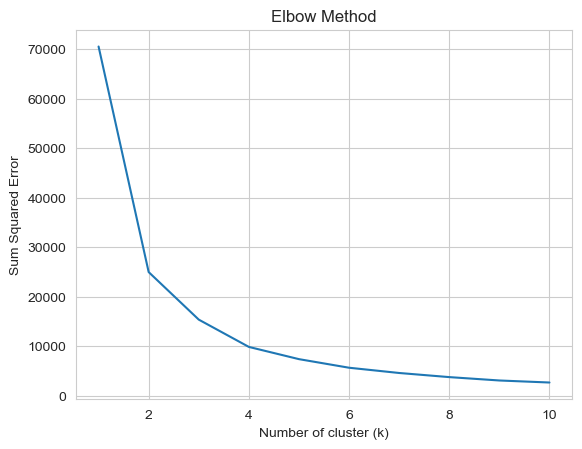

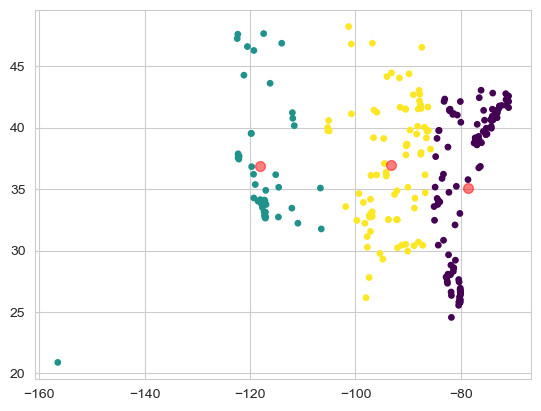

In [265]:
cluster_df_usa, usa_df, usa_centers = kmns(usa_df,3)

plotdf(usa_df, usa_centers, "KMeans USA")


False
False


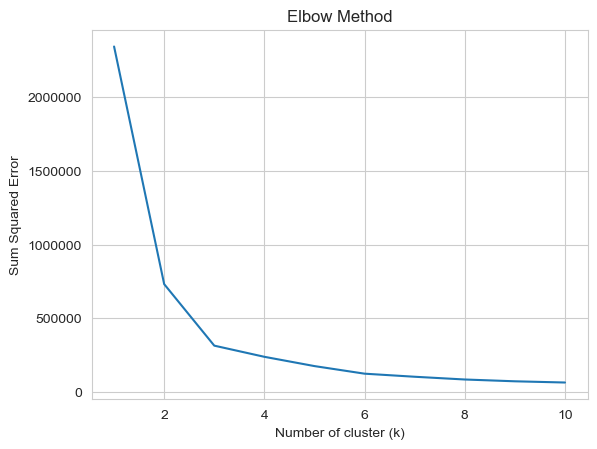

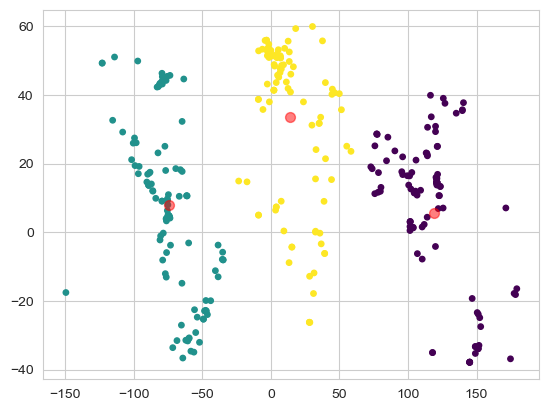

In [267]:
cluster_df_world, world_df, world_centers = kmns(world_df,3)

plotdf(world_df, world_centers, "KMeans World without US")


In [ ]:
#print(usa_centers)
sort_headlines(usa_df, usa_centers, 3)